In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

c:\users\dell\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


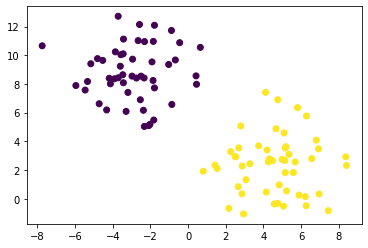

In [2]:
from sklearn.datasets.samples_generator import make_blobs

(X,y) =  make_blobs(n_samples=100,n_features=2,centers=2,cluster_std=2,random_state=42)
X1 = np.c_[np.ones((X.shape[0])),X] #Adding bias term

plt.scatter(X1[:,1],X1[:,2],marker='o',c=y)
plt.show()

(-8.0, 8.0)

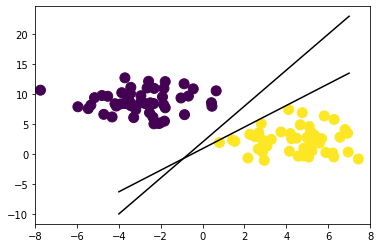

In [3]:
xfit = np.linspace(-4, 7)
plt.scatter(X[:, 0], X[:, 1], c=y, s=100)
for m, b in [(1.8, 0.90), (3, 2)]:
    plt.plot(xfit, m * xfit + b, '-k')
plt.xlim(-8, 8)

(-8.0, 8.0)

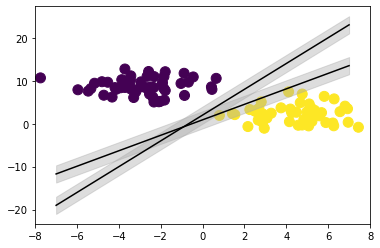

In [4]:
xfit = np.linspace(-7, 7)
plt.scatter(X[:, 0], X[:, 1], c=y, s=100)
for m, b, d in [(1.8, 0.90,2), (3, 2,2)]:
    yfit = m * xfit + b
    plt.plot(xfit, m * xfit + b, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',color='#AAAAAA', alpha=0.4)
plt.xlim(-8, 8)


In [5]:
#Seperate + and - target data
PositiveY = []
NegativeY = []
for i,v in enumerate(y):
    if v==0:
        PositiveY.append(X[i])
    else:
        NegativeY.append(X[i])
    

In [6]:
#Convert 0/1 to -1/+1 dictionary
data_dict = {-1:np.array(NegativeY), 1:np.array(PositiveY)}

In [7]:
#Get max and min features 
min_feature_val = float('+inf')
max_feature_val = float('-inf')

for i in data_dict:
    if np.max(data_dict[i]) > max_feature_val:
        max_feature_val = np.max(data_dict[i])
    if np.min(data_dict[i]) < min_feature_val:
        min_feature_val = np.min(data_dict[i])
    
print("Min feature Value : ",min_feature_val)
print("Max feature Value : ",max_feature_val)

Min feature Value :  -7.748687831232239
Max feature Value :  12.718842497216198


# Approach - 1 (Using convex optimization library)

In [8]:
#Importing with custom names to avoid issues with numpy / sympy matrix
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

#Initializing values and computing H. Note the 1. to force to float type
m,n = X.shape
y = y.reshape(-1,1) * 1.
X_dash = y * X
H = np.dot(X_dash , X_dash.T) * 1.

#Converting into cvxopt format
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(-np.eye(m))
h = cvxopt_matrix(np.zeros(m))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Setting solver parameters (change default to decrease tolerance) 
cvxopt_solvers.options['show_progress'] = False
cvxopt_solvers.options['abstol'] = 1e-10
cvxopt_solvers.options['reltol'] = 1e-10
cvxopt_solvers.options['feastol'] = 1e-10

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

#==================Computing and printing parameters===============================#
#w parameter in vectorized form
w = ((y * alphas).T @ X).reshape(-1,1)

#Selecting the set of indices S corresponding to non zero parameters
S = (alphas > 1e-4).flatten()

#Computing b
b = y[S] - np.dot(X[S], w)

#Display results
#print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])


w =  [3.41517339e-09 1.68698624e-08]
b =  [-1.33963413e-07]


# Approach - 2 (Using convex optimization library with constraint)

In [9]:
#Implementing with additional constraint
C = 10
m,n = X.shape
y = y.reshape(-1,1) * 1.
X_dash = y * X
H = np.dot(X_dash , X_dash.T) * 1.

#Converting into cvxopt format - as previously
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

#==================Computing and printing parameters===============================#
w = ((y * alphas).T @ X).reshape(-1,1)
S = (alphas > 1e-4).flatten()
b = y[S] - np.dot(X[S], w)

#Display results
print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])

Alphas =  [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
w =  [ 2.54340913e-27 -2.13448053e-26]
b =  [1.93301862e-25]


In [10]:
#Comparing to sklearn results
from sklearn.svm import SVC
clf = SVC(C = 10, kernel = 'linear')
clf.fit(X, y.ravel()) 

print('w = ',clf.coef_)
print('b = ',clf.intercept_)

w =  [[ 0.49935747 -0.30072439]]
b =  [1.17655201]


# Approach - 3 

In [11]:
w = []
b = []
learning_rate = [max_feature_val * 0.1, max_feature_val * 0.01, max_feature_val * 0.001,]
def SVM_Training(data_dict):
    i=1
    global w
    global b
    # { ||w||: [w,b] }
    length_Wvector = {}
    transforms = [[1,1],[-1,1],[-1,-1],[1,-1]]
    
    b_step_size = 2
    b_multiple = 5
    w_optimum = max_feature_val*0.5

    for lrate in learning_rate:
        
        w = np.array([w_optimum,w_optimum])     
        optimized = False
        while not optimized:
            #b=[-maxvalue to maxvalue] we wanna maximize the b values so check for every b value
            for b in np.arange(-1*(max_feature_val*b_step_size), max_feature_val*b_step_size, lrate*b_multiple):
                for transformation in transforms:  # transforms = [[1,1],[-1,1],[-1,-1],[1,-1]]
                    w_t = w*transformation
                    
                    correctly_classified = True
                    
                    # every data point should be correct
                    for yi in data_dict:
                        for xi in data_dict[yi]:
                            if yi*(np.dot(w_t,xi)+b) < 1:  # we want  yi*(np.dot(w_t,xi)+b) >= 1 for correct classification
                                correctly_classified = False
                                
                    if correctly_classified:
                        length_Wvector[np.linalg.norm(w_t)] = [w_t,b] #store w, b for minimum magnitude
            
            if w[0] < 0:
                optimized = True
            else:
                w = w - lrate

        norms = sorted([n for n in length_Wvector])
        
        minimum_wlength = length_Wvector[norms[0]]
        w = minimum_wlength[0]
        b = minimum_wlength[1]
        
        w_optimum = w[0]+lrate*2

In [12]:
SVM_Training(data_dict)

In [13]:
print(w)
print(b)

[-0.63594212  0.63594212]
-3.1797106243039934


In [26]:

def visualize(data_dict):
        colors = {1:'r',-1:'b'}
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        print(b)
        print(w)
        plt.scatter(X1[:,1],X1[:,2],marker='o',c=y)
        def hyperplane_value(x,w,b,v):
            return (-w[0]*x-b+v) / w[1]

        datarange = (min_feature_val*0.9,max_feature_val*1.)
        hyp_x_min = datarange[0]
        hyp_x_max = datarange[1]
        print("Hyperplane range ",hyp_x_min,hyp_x_max)

        # (w.x+b) = 1
        # positive support vector hyperplane
        psv1 = hyperplane_value(hyp_x_min, w, b, 1)
        psv2 = hyperplane_value(hyp_x_max, w, b, 1)
        print("positive", psv1, psv2)
        ax.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')

        # (w.x+b) = -1
        # negative support vector hyperplane
        nsv1 = hyperplane_value(hyp_x_min, w, b, -1)
        nsv2 = hyperplane_value(hyp_x_max, w, b, -1)
        print("negative", nsv1, nsv2)
        ax.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'k')

        # (w.x+b) = 0
        # positive support vector hyperplane
        db1 = hyperplane_value(hyp_x_min, w, b, 0)
        db2 = hyperplane_value(hyp_x_max, w, b, 0)
        print("decision boundary", db1, db2)
        ax.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')
        
        
        plt.show()

-3.1797106243039934
[-0.63594212  0.63594212]
Hyperplane range  -6.973819048109015 12.718842497216198
positive -0.4013489114298074 19.291312633895405
negative -3.5462891847884004 16.146372360536812
decision boundary -1.9738190481091038 17.71884249721611


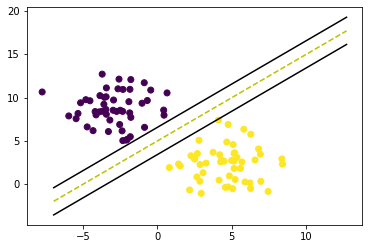

In [27]:
visualize(data_dict)